In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import odeint

In [2]:
para = {}
# 全部的参数都是估计而来，数量级参考了2015 KUL的参数
para.update({'alpha_TGFBR1': 0.0394,'alpha_TGFBR2': 0.0394, 'alpha_Sos': 0.0394,'alpha_Grb2': 0.0394, 'alpha_Shc': 0.0394, 'alpha_Sara': 0.0394, 'alpha_Smad2': 0.0394,'alpha_AI-2': 0.0394, 'alpha_Cqs-S': 0.0394,'alpha_RhoA': 0.0394})  # alpha

para.update({'beta_TGFBR1':0.35, 'beta_TGFBR2':0.35, 'beta_Sos':0.35, 'beta_Grb2':0.35, 'beta_Shc':0.35, 'beta_Sara':0.35, 'beta_Smad2':0.35, 'beta_AI-2':0.35, 'beta_Cqs-S':0.35, 'beta_RhoA':0.35})  # beta

para.update({'k_as,TGFBR2': 1e-5, 'k_dis,TGFBR2': 0.003,'k_as,SGSS': 1e-5, 'k_dis,SGSS': 0.003, 'k_as,AI-2/Cqs-S': 1e-5, 'k_dis,AI-2/Cqs-S': 0.003})  # k

para.update({'d_mTGFBR1': 0.0022, 'd_mTGFBR2': 0.0022, 'd_mSos': 0.0022, 'd_mGrb2': 0.0022, 'd_mShc': 0.0022, 'd_mSara': 0.0022, 'd_mSmad2': 0.0022, 'd_mAI-2': 0.0022, 'd_mCqs-S': 0.0022, 'd_mRhoA': 0.0022, 'd_TGFBR1': 0.0022, 'd_TGFBR2': 0.0022, 'd_Sos': 0.0022, 'd_Grb2': 0.0022, 'd_Shc': 0.0022, 'd_Sara': 0.0022, 'd_Smad2': 0.0022, 'd_AI-2': 0.0022, 'd_Cqs-S': 0.0022, 'd_RhoA': 0.0022, 'd_TGFBR1-P': 0.0022, 'd_Smad2-P': 0.0022, 'd_TGF-b/TGFBR2': 0.0022, 'd_SGSS': 0.0022, 'd_AI-2/Cqs-S': 0.0022, })  # d

para.update({'gTGFBR1':100, 'gTGFBR2':100, 'gSos':100, 'gGrb2':100, 'gShc':100, 'gSara':100, 'gAI-2':100, 'gSmad2':100, 'gCqs-S':100, 'gRhoA':100, })  # gene

para.update({'k_d,Smad2':5, 'n_Smad2':1, 'k_d,AI-2':5, 'n_AI-2':1, 'k_d,pLuxU':5, 'n_pLuxU':1, 'k_d,pSos':5, 'n_pSos':1, 'k_d,pGrb2':5, 'n_pGrb2':1, 'k_d,pShc':5, 'n_pShc':1, 'k_d,pSara':5, 'n_pSara':1, })  # kd and n: Hill-Function

para.update({'v_max,TGFBR1-P':0.003, 'v_max,Smad2-P':0.003, 'k_m,TGFBR1': 5, 'k_m,Smad2':5})  # v and km: Mi-Equation

para.update({'TGF-beta':100})  # key:input

# 这里的参数选取了较小的值，可以防止解ode过程中divide by zero的报错
ini = np.ones(25) * 1e-8  # ODE initial value

In [3]:
def dx(x, t):
    mTGFBR1, TGFBR1, mTGFBR2, TGFBR2, TGF_beta_TGFBR2, TGFBR1_P, mSos, Sos, mGrb2, Grb2, mShc, Shc, mSara, Sara, SGSS, mSmad2, Smad2, Smad2_P, mAI2, AI2,mCqs, Cqs, AI2_Cqs, mRhoA, RhoA = x # 解耦

    dx = np.zeros(25)
    # 接下来对照着latex公式和参数表输入
    # mTGFBR1
    dx[0] = para['alpha_TGFBR1'] * para['gTGFBR1'] - para['d_mTGFBR1'] * mTGFBR1
    # TGFBR1
    dx[1] = para['beta_TGFBR1'] * mTGFBR1 - para['v_max,TGFBR1-P'] * TGF_beta_TGFBR2 / (para['k_m,TGFBR1'] + TGFBR1) - para['d_TGFBR1'] * TGFBR1
    # mTGFBR2
    dx[2] = para['alpha_TGFBR2'] * para['gTGFBR2'] - para['d_mTGFBR2'] * mTGFBR2
    # TGFBR2
    dx[3] = para['beta_TGFBR2'] * mTGFBR2 - para['d_TGFBR2'] * TGFBR2 + para['k_dis,TGFBR2'] * TGF_beta_TGFBR2 - para['k_as,TGFBR2'] * TGFBR2 * para['TGF-beta']
    # TGF-beta / TGFBR2
    dx[4] = - para['k_dis,TGFBR2'] * TGF_beta_TGFBR2 + para['k_as,TGFBR2'] * TGFBR2 * para['TGF-beta'] - para['d_TGF-b/TGFBR2'] * TGF_beta_TGFBR2
    # TGFBR1-P
    dx[5] = para['v_max,TGFBR1-P'] * TGF_beta_TGFBR2 * TGFBR1 / (para['k_m,TGFBR1'] + TGFBR1) - para['d_TGFBR1-P'] * TGFBR1_P
    # mSos
    dx[6] = para['alpha_Sos'] / ( 1 + (para['k_d,pSos']/TGFBR1_P) ** para['n_pSos'] ) * para['gSos'] - para['d_mSos'] * mSos
    #Sos
    dx[7] = para['beta_Sos'] * mSos - para['d_Sos'] * Sos - para['k_as,SGSS']*Sos*Grb2*Shc*Sara + para['k_dis,SGSS']*SGSS
    # mGrb2
    dx[8] = para['alpha_Grb2'] / ( 1 + (para['k_d,pGrb2']/TGFBR1_P) ** para['n_pGrb2'] ) * para['gGrb2'] - para['d_mGrb2'] * mGrb2
    #Grb2
    dx[9] = para['beta_Grb2'] * mGrb2 - para['d_Grb2'] * Grb2 - para['k_as,SGSS']*Sos*Grb2*Shc*Sara + para['k_dis,SGSS']*SGSS
    # mShc
    dx[10] = para['alpha_Shc'] / ( 1 + (para['k_d,pShc']/TGFBR1_P) ** para['n_pShc'] ) * para['gShc'] - para['d_mShc'] * mShc
    # Shc
    dx[11] = para['beta_Shc'] * mShc - para['d_Shc'] * Shc - para['k_as,SGSS']*Sos*Grb2*Shc*Sara + para['k_dis,SGSS']*SGSS
    # mSara
    dx[12] = para['alpha_Sara'] / ( 1 + (para['k_d,pSara']/TGFBR1_P) ** para['n_pSara'] ) * para['gSara'] - para['d_mSara'] * mSara
    # Sara
    dx[13] = para['beta_Sara'] * mSara - para['d_Sara'] * Sara - para['k_as,SGSS']*Sos*Grb2*Shc*Sara + para['k_dis,SGSS']*SGSS
    # SGSS
    dx[14] = para['k_as,SGSS']*Sos*Grb2*Shc*Sara - para['k_dis,SGSS']*SGSS - para['d_SGSS'] * SGSS
    # mSmad2
    dx[15] = para['alpha_Smad2'] / ( 1 + (para['k_d,Smad2']/SGSS) ** para['n_Smad2'] ) * para['gSmad2'] - para['d_mSmad2'] * mSmad2
    # Smad2
    dx[16] = para['beta_Smad2'] * mSmad2 - para['d_Smad2'] * Smad2 - para['v_max,Smad2-P'] * TGFBR1_P * Smad2 / (para['k_m,Smad2'] + Smad2) 
    # Smad2-P
    dx[17] = para['v_max,Smad2-P'] * TGFBR1_P * Smad2 / (para['k_m,Smad2'] + Smad2) - para['d_Smad2-P'] * Smad2_P
    # mAI-2
    dx[18] = para['alpha_AI-2'] / ( 1 + (para['k_d,AI-2']/Smad2_P) ** para['n_AI-2'] ) * para['gAI-2'] - para['d_AI-2'] * mAI2
    # AI-2
    dx[19] = para['beta_AI-2'] * mAI2 - para['d_AI-2'] * AI2 - para['k_as,AI-2/Cqs-S'] * AI2 * Cqs + para['k_dis,AI-2/Cqs-S'] * AI2_Cqs
    # mCqs-S
    dx[20] = para['alpha_Cqs-S'] * para['gCqs-S'] - para['d_mCqs-S'] * mCqs
    # Cqs-S
    dx[21] = para['beta_Cqs-S'] * mCqs - para['d_Cqs-S'] * Cqs - para['k_as,AI-2/Cqs-S'] * AI2 * Cqs + para['k_dis,AI-2/Cqs-S'] * AI2_Cqs
    # AI-2/Cqs-S
    dx[22] = para['k_as,AI-2/Cqs-S'] * AI2 * Cqs - para['k_dis,AI-2/Cqs-S'] * AI2_Cqs - para['d_AI-2/Cqs-S'] * AI2_Cqs
    # mRhoA
    dx[23] = para['alpha_RhoA'] / ( 1 + (para['k_d,pLuxU']/AI2_Cqs) ** para['n_pLuxU'] ) * para['gRhoA'] - para['d_RhoA'] * mRhoA
    # RhoA
    dx[24] = para['beta_RhoA'] * mRhoA - para['d_RhoA'] * RhoA 
    return dx


In [6]:
# 模拟5000个单位
t = np.linspace(1,5000,5000)
# 改变input得到off 和 on两种模式
para.update({'TGF-beta':1e-8})  # off mode 
x_off = odeint(dx,ini,t)
para.update({'TGF-beta':100})  # on mode 
x_on = odeint(dx,ini,t)

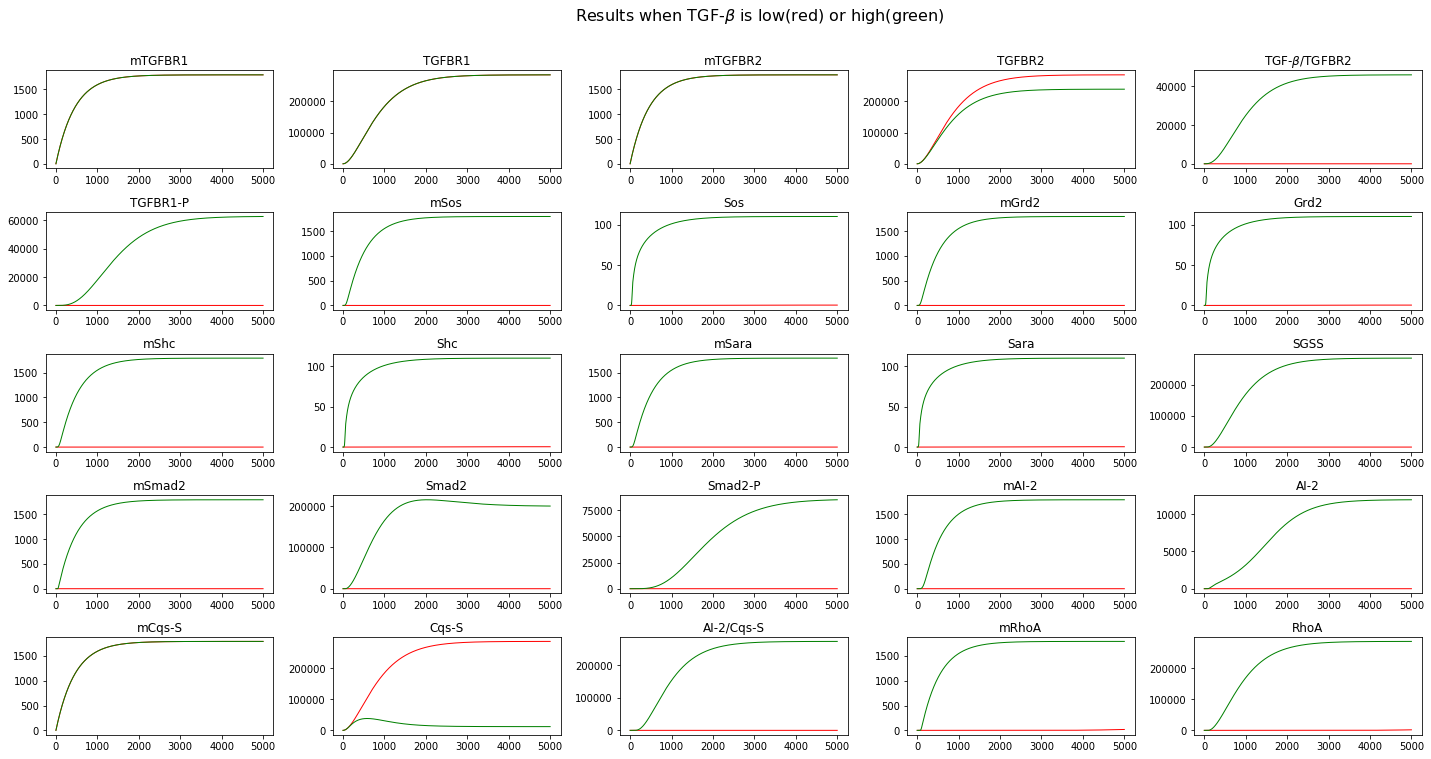

In [10]:
# 绘图
titles = ['mTGFBR1', 'TGFBR1', 'mTGFBR2', 'TGFBR2', r'TGF-$\beta$/TGFBR2', 'TGFBR1-P', 'mSos', 'Sos', 'mGrd2', 'Grd2', 'mShc', 'Shc', 'mSara', 'Sara', 'SGSS', 'mSmad2', 'Smad2', 'Smad2-P', 'mAI-2', 'AI-2', 'mCqs-S', 'Cqs-S', 'AI-2/Cqs-S', 'mRhoA', 'RhoA']  # 各个子图的title
fig = plt.figure(figsize=(20,10))
for i in range(5):
    for j in range(5):
        count = 5*i + j
        plt.subplot(5,5,count+1)
        plt.plot(t, x_off[:,count], color='red', linewidth=1)
        plt.plot(t, x_on[:,count], color='green', linewidth=1)
        plt.title(titles[count])
fig.suptitle(r'Results when TGF-$\beta$ is low(red) or high(green)',fontsize=16,x=0.53,y=1.05,)
# plt.title(r'Results when TGF-$\beta$ is low(red) or high(green)')
fig.tight_layout() 
fig.savefig('./model_wp.png', bbox_inches = 'tight')
fig.show()